In [1]:
import numpy as np
from keras import layers,models
from keras import backend 
from keras.losses import binary_crossentropy
from keras.datasets import mnist
import numpy as np

Using TensorFlow backend.


In [2]:
#Set the hyperparameters - These are not updated during training time
batch_size = 100 #usually it is 128/256 to accomodate GPUs
originalDim = 28*28
latentDim = 2
intermediate = 256
nb_epoch = 50
epsilon_std = 1.0


In [3]:
#The sampling helper function 
def sampling(args):
    z_mean,z_log_var = args
    epsilon = backend.random_normal(shape = (batch_size,latentDim),mean = 0.)
    return z_mean + backend.exp(z_log_var/2)*epsilon
#Create the encoder 
x = layers.Input(shape = (originalDim,),name = 'input')
h = layers.Dense(intermediate,activation = 'relu',name = 'encoding')(x)
z_mean = layers.Dense(latentDim,name = 'Mean')(h)
z_log_var = layers.Dense(latentDim,name = 'Log-variance')(h)
z = layers.Lambda(sampling,output_shape = (latentDim,))([z_mean,z_log_var])
encoder = models.Model(x,[z_mean,z_log_var,z],name = 'encoder')


In [4]:
#Write the decoder 
input_decoder = layers.Input(shape = (latentDim,),name = 'decoder_input')
decoder_h = layers.Dense(intermediate,activation = 'relu',name = 'decoder_h')(input_decoder)
x_decoded = layers.Dense(originalDim,activation='sigmoid',name = 'flat_decoded')(decoder_h)
decoder = models.Model(input_decoder,x_decoded,name = 'decoder')

In [5]:
#Combine the model 
output_combined = decoder(encoder(x)[2])
vae = models.Model(x,output_combined)
vae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [6]:
#Loss function 
def vaeLoss(x,x_decoded_mean,z_log_var=z_log_var,z_mean=z_mean,originalDim = originalDim):
    xent_loss = originalDim*binary_crossentropy(
    x,x_decoded_mean)
    k1_loss = -0.5*backend.sum(1 + z_log_var - backend.square(z_mean) - backend.exp(z_log_var),axis = -1)
    return xent_loss + k1_loss
vae.compile(optimizer = 'rmsprop',loss = vaeLoss)
vae.summary()


    

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [7]:
#Create the test and train split 
(x_train,y_train),(x_test,y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0
x_train = x_train.reshape((len(x_train),np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test),np.prod(x_test.shape[1:])))
#Fit the model finally 
vae.fit(x_train,x_train,shuffle = True,epochs = nb_epoch,batch_size = batch_size,verbose = 1)

Epoch 1/50
60000/60000 [==============================] - 7s 112us/step - loss: 189.0105
Epoch 2/50
60000/60000 [==============================] - 6s 104us/step - loss: 168.7475
Epoch 3/50
60000/60000 [==============================] - 6s 107us/step - loss: 165.4555
Epoch 4/50
60000/60000 [==============================] - 7s 110us/step - loss: 163.3888
Epoch 5/50
60000/60000 [==============================] - 8s 132us/step - loss: 161.6269
Epoch 6/50
60000/60000 [==============================] - 8s 139us/step - loss: 160.1338
Epoch 7/50
60000/60000 [==============================] - 7s 119us/step - loss: 158.8930
Epoch 8/50
60000/60000 [==============================] - 7s 112us/step - loss: 157.9226
Epoch 9/50
60000/60000 [==============================] - 7s 125us/step - loss: 157.1822
Epoch 10/50
60000/60000 [==============================] - 8s 140us/step - loss: 156.5474
Epoch 11/50
60000/60000 [==============================] - 6s 103us/step - loss: 156.0084
Epoch 12/50
60000/6

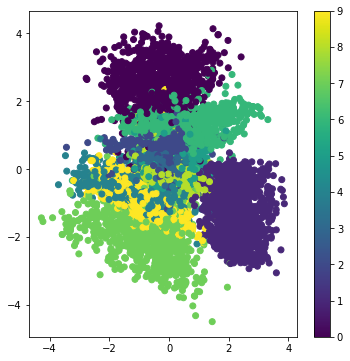

In [8]:
#Display a 2D plot of the digit classes 
import matplotlib.pyplot as plt
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()


In [9]:
#Display a manifold of digits 
from scipy.stats import norm
n = 20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i,yi in enumerate(grid_x):
    for j,xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='Greys_r')
plt.show()

NameError: name 'norm' is not defined